In [376]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
%matplotlib inline

In [377]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#Pass all of the data, both test and train, into our cleaning function.
#Leave Id and SalePrice out because we don't want our model to predict from these.
all_df = pd.concat((train_df.drop(['Id', 'SalePrice'], axis=1),
                      test_df.drop('Id', axis=1)))

In [378]:
from scipy.stats import skew

In [379]:
def clean_data(df):
    numeric_vars = df.select_dtypes(['float64', 'int64']).columns
    data_numeric = df[numeric_vars]
    
    skewed_feats = data_numeric.apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    
    data_numeric[skewed_feats] = np.log1p(data_numeric[skewed_feats])
    data_num_norm = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
    
    data_cat = df.select_dtypes(['object'])
    
    result_df = pd.concat([pd.get_dummies(data_cat),data_num_norm], axis=1)
    result_df = result_df.fillna(result_df.mean())
    
    return result_df

In [380]:
#Just to check what the skewed features are.
data_numeric = all_df[all_df.select_dtypes(['float64', 'int64']).columns]
skewed_feats = data_numeric.apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats

Index([u'MSSubClass', u'LotFrontage', u'LotArea', u'MasVnrArea', u'BsmtFinSF1',
       u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF',
       u'LowQualFinSF', u'GrLivArea', u'BsmtHalfBath', u'KitchenAbvGr',
       u'TotRmsAbvGrd', u'WoodDeckSF', u'OpenPorchSF', u'EnclosedPorch',
       u'3SsnPorch', u'ScreenPorch', u'PoolArea', u'MiscVal'],
      dtype='object')

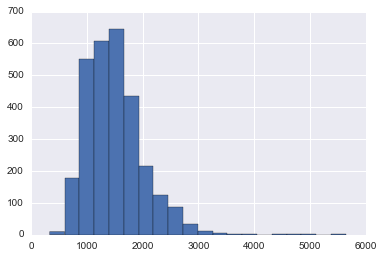

In [381]:
#data_numeric['GrLivArea'].apply(lambda x: np.log1p(x)).hist(bins=20)
data_numeric['GrLivArea'].hist(bins=20)

In [382]:
data_all = clean_data(all_df)

In [383]:
data_all.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0,0,0,1,0,0,1,0,0,0,...,0.050488,-0.337330,0.271398,-0.109445,-0.010621,-0.07097,-0.004092,-0.024101,-0.383008,0.051816
1,0,0,0,1,0,0,1,0,0,0,...,-0.008652,0.447647,-0.352914,-0.109445,-0.010621,-0.07097,-0.004092,-0.024101,-0.110281,-0.198184
2,0,0,0,1,0,0,1,0,0,1,...,0.090810,-0.337330,0.216043,-0.109445,-0.010621,-0.07097,-0.004092,-0.024101,0.253356,0.051816
3,0,0,0,1,0,0,1,0,0,1,...,0.113660,-0.337330,0.189165,0.701093,-0.010621,-0.07097,-0.004092,-0.024101,-0.383008,-0.448184
4,0,0,0,1,0,0,1,0,0,1,...,0.244036,0.387366,0.319126,-0.109445,-0.010621,-0.07097,-0.004092,-0.024101,0.526083,0.051816


In [385]:
#Recover which rows were test and which were train
train_data_all = data_all[:train_df.shape[0]]
test_data_all = data_all[train_df.shape[0]:]

In [386]:
X = train_data_all.values
y = np.log1p(train_df['SalePrice'].values)
#y = train_df['SalePrice'].values

In [392]:
def get_mse(X, y, a):
    x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 37)


    #regr = linear_model.Ridge(alpha = a)
    regr = linear_model.Lasso(alpha = a, normalize = False)
    regr.fit(x_train, y_train)
    
    #return np.sqrt(np.mean((np.log(regr.predict(x_validation) )- np.log(y_validation))** 2))
    return np.sqrt(np.mean(regr.predict(x_validation) - y_validation)** 2)

In [393]:
alpha_optimization_df = pd.DataFrame({'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1]})
#alpha_optimization_df = pd.DataFrame({'alpha': [1, 2,3,4,5,10,20,30,40]})
alpha_optimization_df['mse'] = alpha_optimization_df['alpha'].apply(lambda a: get_mse(X, y, a))
alpha_optimization_df.head()

,alpha,mse
0,0.0001,0.002085
1,0.0010,0.001906
2,0.0100,0.001057
3,0.1000,0.018632
4,1.0000,0.018827


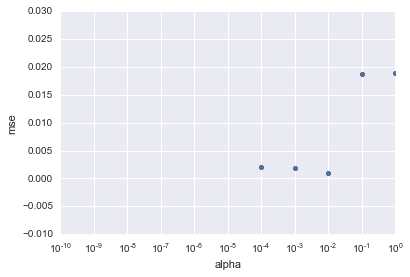

In [394]:
alpha_optimization_df.plot(x = 'alpha', y = 'mse', kind = 'scatter', xlim=[1e-10, 1], logx=True)

Looks like the best alpha is around 10 for ridge and around 0.005 for lasso.  

In [395]:
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 37)

#regr = linear_model.LinearRegression()
regr = linear_model.Ridge(alpha = 10)
regr.fit(x_train, y_train)
#print('Coefficients: ', regr.coef_)
print('Intercept: ', regr.intercept_)
print("Root Mean squared error: %.4f" % np.sqrt(np.mean((np.log(regr.predict(x_validation) )- np.log(y_validation))** 2)))

('Intercept: ', 11.800783398985292)
Root Mean squared error: 0.0122


In [416]:
x_train, x_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.33, random_state = 37)

#regr = linear_model.LinearRegression()
lasso = linear_model.Lasso(alpha = 1e-2)
lasso.fit(x_train, y_train)
#print('Coefficients: ', regr.coef_)
print('Intercept: ', regr.intercept_)

err = (np.expm1(lasso.predict(x_validation))- np.expm1(y_validation))/np.expm1(y_validation)

print("Root Mean squared error: %.4f" % np.sqrt(np.mean((np.log(lasso.predict(x_validation) )- np.log(y_validation))** 2)))
print("Root Mean squared error: %.4f" % np.mean(abs(err)))

('Intercept: ', 11.800783398985292)
Root Mean squared error: 0.0143
Root Mean squared error: 0.1227


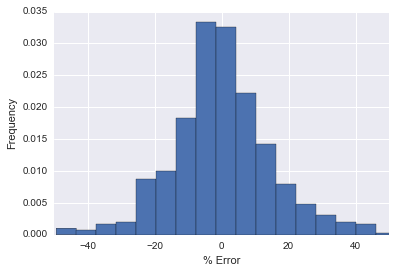

In [439]:
plt = pd.DataFrame({' ': err*100}).hist(bins=40, normed = True)
plt[0][0].set_xlim([-50,50])
plt[0][0].set_xlabel("% Error")
plt[0][0].set_ylabel("Frequency")

In [440]:
coef.head()

MSZoning_C (all)   -0.000000
MSZoning_FV         0.000000
MSZoning_RH         0.000000
MSZoning_RL         0.003125
MSZoning_RM        -0.000000
dtype: float64

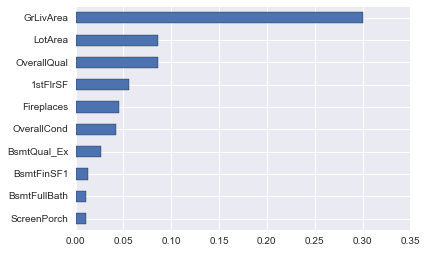

In [441]:
coef.sort_values().tail(10).plot(kind = 'barh')

## Create the Test Set for Upload

In [349]:
X_test = test_data_all.values

In [350]:
#preds = np.expm1(regr.predict(X_test))
preds = np.expm1(lasso.predict(X_test))

In [351]:
solution = pd.DataFrame({"id":test_df.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [352]:
solution.head()

,SalePrice,id
0,123358.283078,1461
1,159618.733948,1462
2,185361.661424,1463
3,197362.668298,1464
4,199249.865978,1465
